In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, argparse


In [2]:
processors = pd.read_csv("chiplet_cfp_study_permutation.csv")
processors['Area Permutation'] = None
processors['Mfg CFP Permutation'] = None

processors

,Product,Process Size (nm),TDP (W),DieSizeValue,Die Size (mm^2),#dies,Avg Die Area,Emb CFP Chiplet,Ope CFP Chiplet,Tot CFP Chiple,Area Permutation,Mfg CFP Permutation
0,R-9-3950X,7,105,148,2x 74,2,74,4.082265,83.364365,87.446629,None,None
1,R-9-5950X,7,105,148,2x 74,2,74,4.082265,83.364365,87.446629,None,None
2,T-3990X,7,280,592,8x 74,8,74,17.065189,222.304972,239.370161,None,None
3,T-PRO-3995WX,7,280,592,8x 74,8,74,17.065189,222.304972,239.370161,None,None
4,T-PRO-5995WX,7,280,648,8x 81,8,81,18.890709,222.304972,241.195681,None,None


In [3]:
dies = np.array([1, 2, 4 ,8])
for idx, proc in processors.iterrows():
    area_permutation = []
    for die in dies:
        area = proc['DieSizeValue']/die
        area_permutation.append(area)
    processors.at[idx, 'Area Permutation'] = area_permutation

In [5]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(parent_dir)
import utils
defective_density_sequence, epa_sequence, gpa_sequence, carbon_intensity_sequence = utils.generate_probabilistic_sequences()


In [6]:
import eco_chip_enhanced
sample_size = len(carbon_intensity_sequence)
for idx, proc in processors.iterrows():
    node = int(proc['Process Size (nm)'])
    power = int(proc['TDP (W)'])
    src = f'../../eco_chip_enhanced/arch_params/'
    mfg_carbon_list = np.zeros(sample_size)
    mfg_carbon_mean_list = []
    for (die, area) in zip(dies, proc['Area Permutation']):
        dest = f'chiplet_arch_params_{idx}/'
        utils.copy_design_operation_package(src=src, dest=dest)
        utils.generate_node_arch(die, node, area, dest)      
        for i in range(sample_size):
            args = argparse.Namespace(
                design_dir = dest,
                chip_area = area,
                chip_power = power,
                node = node,
                defect_density = defective_density_sequence[str(node)][i],
                gpa = gpa_sequence[i], 
                epa = epa_sequence[str(node)][i],
                epa_pack = epa_sequence['65'][i],
                defect_density_pack = defective_density_sequence['65'][i],
                num_lifetime= None,
                tech_scaling_path= None,
                carbon_intensity = carbon_intensity_sequence[i]
            )

            design_carbon, mfg_carbon, ope_carbon, total_carbon = eco_chip_enhanced.eco_chip(args)
            mfg_carbon_list[i] = mfg_carbon    
        mfg_carbon_mean = mfg_carbon_list.mean()
        mfg_carbon_mean_list.append(mfg_carbon_mean)
    processors.at[idx, 'Mfg CFP Permutation'] = mfg_carbon_mean_list



In [8]:
# if you are reading the original CSV files in stead generate the files, you should run the following
import ast
ecfp_permutation = []
for idx, proc in processors.iterrows():
    if type(proc['Mfg CFP Permutation']) is str:
        temp = ast.literal_eval(proc['Mfg CFP Permutation'])
        ecfp_permutation.append(temp)
    else:
        ecfp_permutation.append(proc['Mfg CFP Permutation'])
ecfp_permutation = np.array(ecfp_permutation)




In [ ]:
# normalize the CFP numbers to their default vendor configuration
for i in range(len(ecfp_permutation)):
    original_die = int(processors.iloc[i]['#dies'])
    idx = np.where(dies == original_die)
    ecfp_permutation[i] = ecfp_permutation[i] / ecfp_permutation[i][idx]
for i in range(len(dies)):
    col = f"Die{dies[i]}"
    processors[f"Die{dies[i]}"] = ecfp_permutation[:,i]

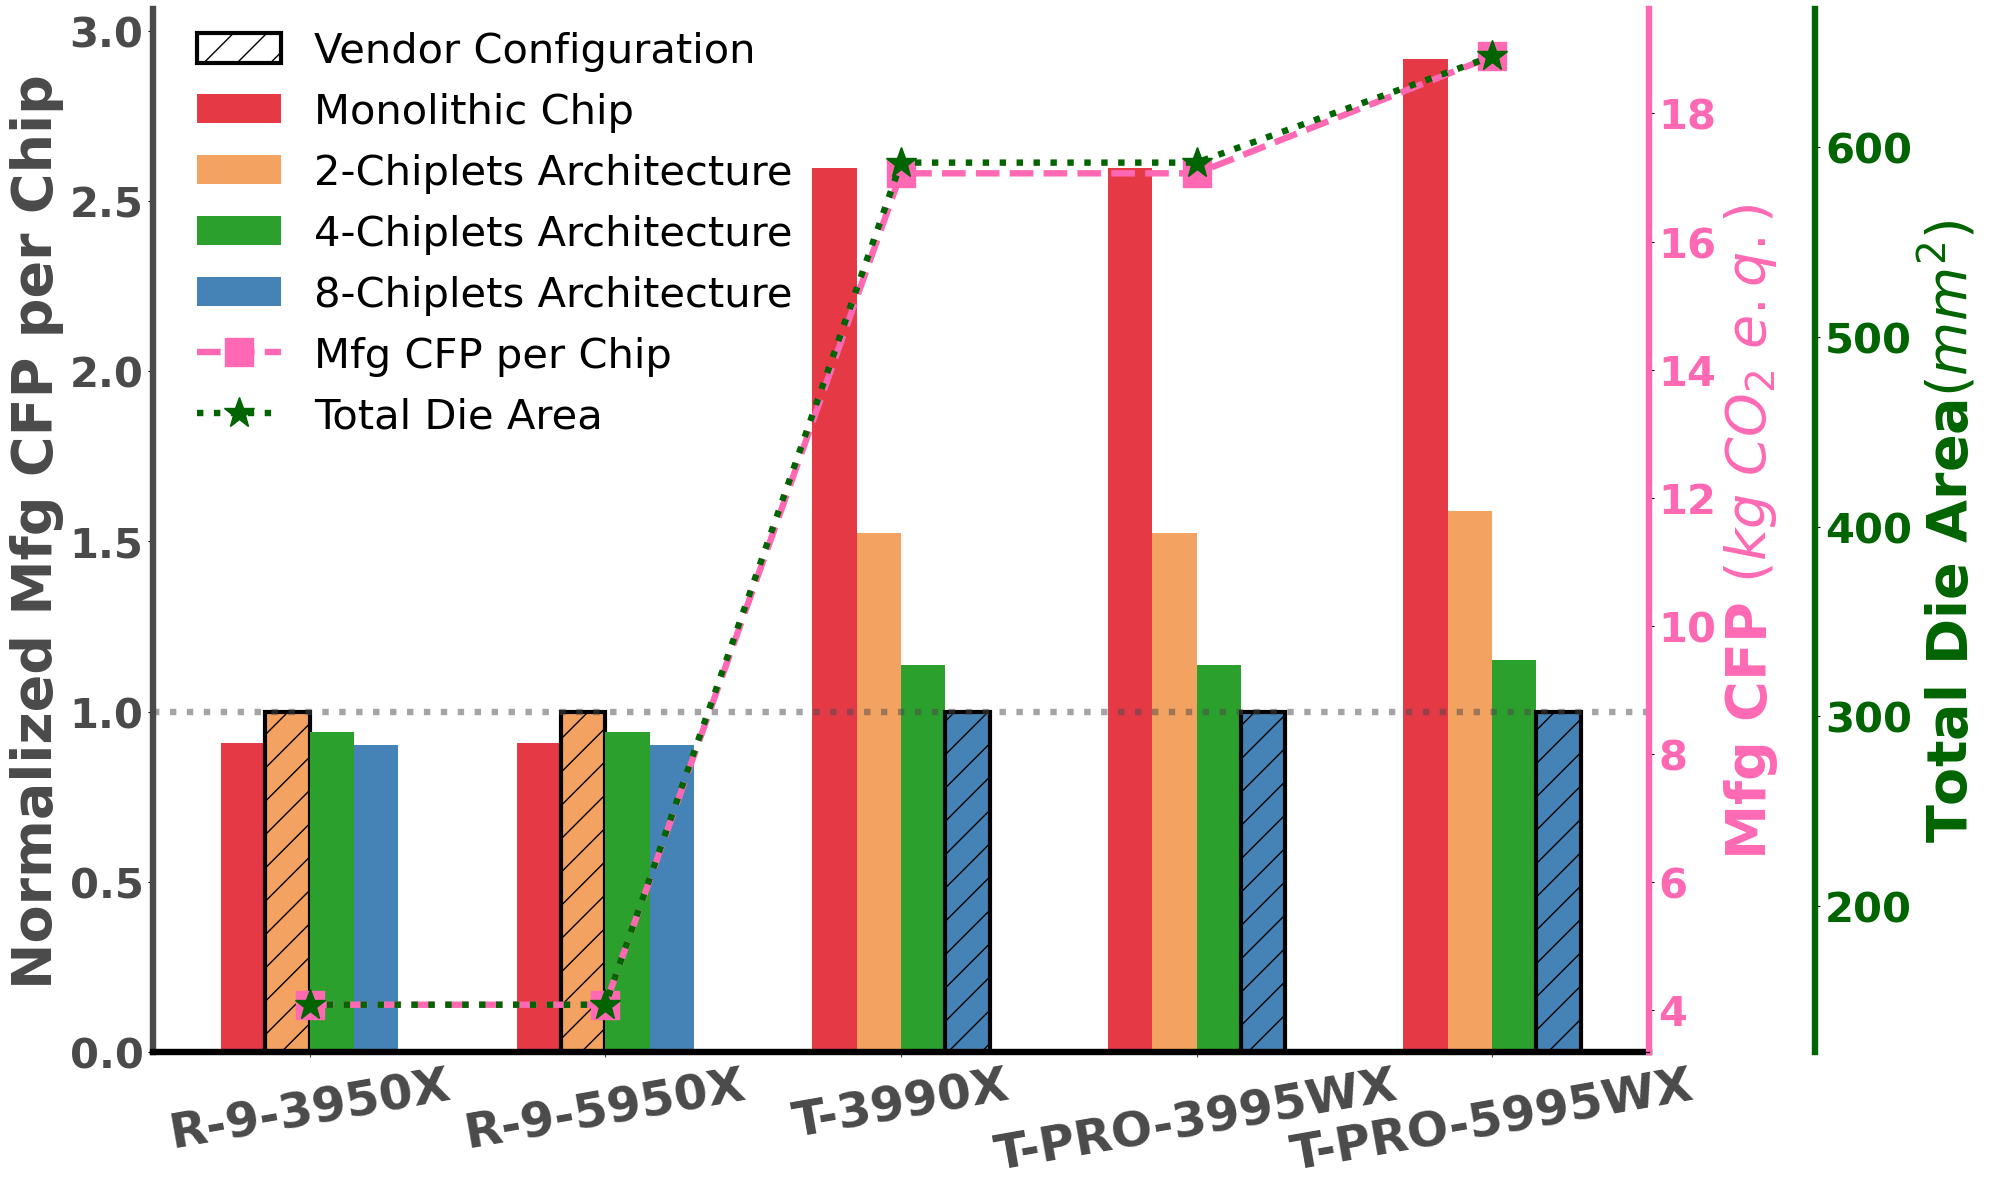

In [10]:

def plot_processors(processors):
    factor = 2
    color0 = '#4a4a4a'  # Dark gray
    color1 = '#E63946'  # Bright red

    color2 = '#FF69B4'  # Darker pink # pink blue

    color3 = '#2ca02c'  # green
    color4 = '#4583B6'  # Rich navy blue for contrast
    color5 = '#006400'  # Bright warm yellow-orange

    color6 = '#F4A261'  # origin
    
    fig_width = 20  # Set a minimum width of 10, scale with number of products
    fig_height = 12  # Fixed height for better readability

    legend_size = 15 * factor
    label_size = 20 * factor
    tick_font_size = 15 * factor
    line_width = 2.3 * factor
    marker_size = 10 * factor

    fig, ax1 = plt.subplots(figsize=(fig_width, fig_height))

    legend_handles = []

    ax1.spines['bottom'].set_linewidth(line_width)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_linewidth(line_width)
    ax1.spines['left'].set_color(color0)
    ax1.spines['top'].set_visible(False)
    # ax1.set_ylim(0, ax1.get_ylim()[1] * 2)
    # max_tick = ax1.get_ylim()[1] * 0.75
    # ax1.set_yticks(np.arange(0, max_tick, max_tick / 5))

    ax1.set_ylabel('Normalized Mfg CFP per Chip', fontsize=label_size, fontweight='bold', color=color0)
    bar_width = 0.15
    index = np.arange(len(processors['Product']))
    die1 = ax1.bar(index - 1.5 * bar_width, processors['Die1'], bar_width, color=color1)
    die2 = ax1.bar(index - 0.5 * bar_width, processors['Die2'], bar_width, color=color6)
    die4 = ax1.bar(index + 0.5 * bar_width, processors['Die4'], bar_width, color=color3)
    die8 = ax1.bar(index + 1.5 * bar_width, processors['Die8'], bar_width, color=color4)

    default_configure_bars = [die2.patches[0], die2.patches[1], die8.patches[2], die8.patches[3], die8.patches[4]]
    from matplotlib.patches import Patch
    haded_legend_patch = Patch(facecolor='white', edgecolor='black', hatch='/', linewidth=3, label='Default Chiplets + Packaging Configuration')

    for bar in default_configure_bars:
        bar.set_hatch('/')
        bar.set_edgecolor('black')
        bar.set_linewidth(3)
        bar.set_label('Default Chiplets + Packaging Configuration')
    
    calibration = ax1.axhline(y=1.0, color=color0, linestyle=':', linewidth=line_width, alpha=0.5)
    legend_handles.append(haded_legend_patch)
    legend_handles.append(die1)
    legend_handles.append(die2.patches[3])
    legend_handles.append(die4)
    legend_handles.append(die8)


    ax1.tick_params(axis='y', labelcolor=color0)
    ax1.set_xticks(index)
    ax1.tick_params(axis='x', colors=color0)
    ax1.set_xticklabels(processors['Product'])
    for tick in ax1.get_xticklabels():
        tick.set_fontsize(tick_font_size + 5)
        tick.set_fontweight('bold')
        tick.set_rotation(10)

    for tick in ax1.get_yticklabels():
        tick.set_fontsize(tick_font_size)
        tick.set_fontweight('bold')


    ax2 = ax1.twinx()
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_color(color2)
    ax2.spines['right'].set_linewidth(line_width)
    ax2.spines['left'].set_visible(False)

    ax2.set_ylabel(r'Mfg CFP $(kg\ CO_2\ e.q.)$', fontsize=label_size, fontweight='bold', color=color2)
    emb_cfp_chiplet, = ax2.plot(processors['Product'], processors['Emb CFP Chiplet'], color=color2, linestyle='--', label='Emb CFP Chiplet', linewidth=line_width, marker='s', markersize=marker_size)
    legend_handles.append(emb_cfp_chiplet)
    ax2.tick_params(axis='y', labelcolor=color2)

    for tick in ax2.get_yticklabels():
        tick.set_fontsize(tick_font_size)
        tick.set_fontweight('bold')
        tick.set_color(color2)


    ax3 = ax1.twinx()
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_position(('outward', 120))
    ax3.spines['right'].set_color(color5)
 
    ax1.xaxis.label.set_color(color0)
    ax3.spines['right'].set_linewidth(line_width)
    ax3.spines['left'].set_visible(False)

    ax3.set_ylabel(r'Total Die Area$(mm^2)$', fontsize=label_size, fontweight='bold', color = color5)
    dieSizeValue, = ax3.plot(processors['Product'], processors['DieSizeValue'], color=color5, linestyle=':', label='Total Die Area', linewidth=line_width, marker='*', markersize=marker_size+3)
    legend_handles.append(dieSizeValue)
    ax3.tick_params(axis='y', labelcolor=color5)

    for tick in ax3.get_yticklabels():
        tick.set_fontsize(tick_font_size)
        tick.set_fontweight('bold')
        tick.set_color(color5)

    # extra_handle1 = Patch(facecolor='none', edgecolor='none', label='Extra Handle 1')
    # extra_handle2 = Patch(facecolor='none', edgecolor='none', label='Extra Handle 2')
    # legend_handles.append(extra_handle1)
    # legend_handles.append(extra_handle2)

    legend_labels = ['Vendor Configuration','Monolithic Chip', '2-Chiplets Architecture', '4-Chiplets Architecture', '8-Chiplets Architecture',
                     'Mfg CFP per Chip','Total Die Area']
    fig.legend(legend_handles, legend_labels, loc='upper center',fontsize=legend_size, frameon=False, ncol=1, bbox_to_anchor=(0.25, 1.0))


    fig.tight_layout()
    return fig

# Example usage
fig = plot_processors(processors)
fig.savefig("chiplet_cfp_study.pdf", bbox_inches='tight', dpi=300)
